In [227]:
load_data = True
# chooses whether to import from datasets or run code (scrapers, etc.) again

# Star Wars Networking Through Scripts and SWAPI

## Import and prep Scripts

Scripts dataset found on [GitHub](https://github.com/jcwieme/data-scripts-star-wars)

### Functions

In [228]:
import networkx as nx
import pandas as pd
from collections import defaultdict
import netwulf as nw
from netwulf import visualize as _visualize
from itertools import combinations
import matplotlib.pyplot as plt


movie_data_path = '../data/movies/'

community_mapping = pd.read_csv(f'{movie_data_path}movie_characters_mapping.csv', sep=';')
name_map = dict(
    zip(
        community_mapping['raw_name'].str.strip().str.lower(),
        community_mapping['translation_name'].str.strip().str.lower()
    )
)

def translate(raw_char):
    return name_map.get(raw_char.strip().lower(), raw_char.strip().lower())

### Execution

In [229]:
load_data = False

if load_data:
    df_script = pd.read_csv('../data/movies/moviescripts_compiled.csv')
else:    
    df_script = pd.DataFrame(columns=['from', 'where', 'text', 'movie_num'])

    for movie_num in range(1, 7):
        current_movie_path = f'star_wars_{movie_num}_data.csv'
        current_movie = pd.read_csv(movie_data_path + current_movie_path, sep=';')

        current_movie.replace({'from': {'nan': pd.NA}, 'to': {'nan': pd.NA}}, inplace=True)
        current_movie = current_movie[['from', 'where', 'text']]
        current_movie['movie_num'] = movie_num

        df_script = pd.concat([df_script, current_movie], ignore_index=True)

    df_script['from'] = df_script['from'].str.lower()
    df_script['text_processed'] = df_script['text'].str.lower().str.replace(r'[^a-z\s]', '', regex=True)
    
    df_script['from'] = df_script['from'].apply(translate)

    # adds trilogy logic for df
    movies_per_char = df_script.groupby('from')['movie_num'].agg(set)
    trilogy_map = {
        name: 1 if nums <= {1,2,3}
        else 2 if nums <= {4,5,6}
        else 'both'
        for name, nums in movies_per_char.items()
    }
    df_script['trilogy'] = df_script['from'].map(trilogy_map)


    df_script.to_csv(f'{movie_data_path}moviescripts_compiled.csv', index=False)

load_data = True

df_script.sample(1)

,from,where,text,movie_num,text_processed,trilogy
4829,c-3po,INT. VADER'S STAR DESTROYER - BRIDGE,"Oh, you did it!",5,oh you did it,both


## Webscraping Wookieepedia

### Functions

In [230]:
from tqdm import tqdm
from bs4 import BeautifulSoup 
import requests
from joblib import Parallel, delayed
import pickle
import pandas as pd
import numpy as np
from rapidfuzz import fuzz, process

def scraper(category_link,original_link):
    pages = {}
    page_num = 1
    while category_link is not None:
        req = requests.get(category_link)
        soup = BeautifulSoup(req.content, "html.parser")
        
        urls = soup.find_all('a', class_='category-page__member-link') # only get ones with class as category-page__member-link 
        links_before = len(pages)
        for link in urls:
            url = original_link + link.get('href')
            # We need to only get charachters and not categories, currently we are getting all links. We use the key to filter out categories:
            key = url.split('/')[-1]
            if 'Category:' not in key:
                pages[key] = url
            
        page_num += 1

        # get next page button using the class
        next_urls = soup.find_all("a", class_='category-page__pagination-next') # In the code on the website we see the letter class for the next page button is category-page__pagination-next
        if next_urls:
            new_url = next_urls[0].get('href')
            if new_url == category_link:
                break 
            else:
                category_link = new_url
        else:
            break
    return pages

def process_page(url):
    req = requests.get(url)
    soup = BeautifulSoup(req.content, "html.parser")

    # get the name of the character
    name = soup.find('h1',class_='page-header__title').text.strip()

    # Get sidebar with info
    sidebar = soup.find('aside')
    # collect all relevant info in the sidebar
    info = {}

    for item in sidebar.find_all('div', class_='pi-item pi-data pi-item-spacing pi-border-color'):
        #get the data:
        info[item["data-source"]] = item.find('div', class_='pi-data-value pi-font').text.strip()

    # remove the references in format [X] from the data
    for key, value in info.items():
        if value is not None:
            info[key] = value.split('[')[0].strip()
        else:
            info[key] = None
    return name,info

def find_best_match(name, choices, threshold=80):
        match, score, _ = process.extractOne(name, choices, scorer=fuzz.token_set_ratio)
        if score >= threshold:
            return match
        return None

### Execution

In [231]:
category_link = 'https://starwars.fandom.com/wiki/Category:Canon_articles'  # all canon articles
original_link = 'https://starwars.fandom.com'

if load_data:
    with open("../data/pages_dict.pkl", "rb") as f:
        pages = pickle.load(f)
else:
    pages = scraper(category_link,original_link)
    with open("../data/pages_dict.pkl", "wb") as f:
        pickle.dump(pages, f)
        
print(f'Number of pages: {len(pages)}')

Number of pages: 49445


In [232]:
if load_data:
    with open("../data/characters_info_only_filled_att.pkl", "rb") as f:
        characters = pickle.load(f)
else:
    characters = {}
    results = Parallel(n_jobs=-1)(
        delayed(process_page)(pages[key]) for key in tqdm(pages.keys(), desc="Processing pages", unit="page", ncols=100)
    )

    # Collect results
    for name, info in results:
        if name and info:
            characters[name] = info
    with open("../data/characters_info_only_filled_att.pkl", "wb") as f:
        pickle.dump(characters, f)

print('Characters in processed data: ', len(characters))

Characters in processed data:  42826


In [233]:
# into dataframe and process text + become column (instead of index)
df = pd.DataFrame.from_dict(characters, orient='index')

df.index.name = 'name'
df.reset_index(inplace=True)

df['name'] = df['name'].str.lower()
df['name'] = df['name'].str.strip()
df['name'] = df['name'].str.replace('"', '', regex=False)

df.sample(1)

,name,manufacturer,type,cost,purpose,species,affiliation,gender,pronouns,hair,...,albums,form,teams,depth,candidates,electorate,stars,arms,satellites,incubationperiod
12148,bant eerin,NaN,NaN,NaN,NaN,Mon Calamari,Jedi Order,Female,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
# filter for first 6 movies
script_names = df_script['from'].str.lower().unique()

# Filter out rows where 'species', "affiliation",... is NaN
filtered_df = df[(df['species'].notna()) | (df["gender"].notna()) | df["class"].notna() | df["eyes"].notna() ]

# filtered_df = df[df['species'].notna()]
all_names = filtered_df['name'].unique().tolist()

# Find best matches for all movie script characters
matched_names = {}
for name in script_names:
    match = find_best_match(name, all_names)
    if match:
        matched_names[name] = match

# Filter the df_all by matched names
matched_df = filtered_df[filtered_df['name'].isin(matched_names.values())].copy()
matched_df.reset_index(drop=True, inplace=True)
matched_df['matched_name'] = matched_df['name'].map({v: k for k, v in matched_names.items()})

# Only keep columns with at least 10% filled
threshold = 0.1  # 10% filled
matched_df = matched_df.loc[:, matched_df.notna().mean() >= threshold]
matched_df

matched_df.sample(1)

,name,species,affiliation,gender,pronouns,hair,skin,homeworld,death,height,eyes,class,mass,apprentices,birth,families,parents,matched_name
40,cliegg lars,Human,White Suns,Male,He/him,Blond (graying),Light,Tatooine,During or after,1.83 meters (6 ft),Blue,NaN,NaN,NaN,NaN,Lars family,Lef Lars,cliegg


## Import and prep SWAPI (Star Wars API)

### Functions

In [235]:
import requests
import pandas as pd

def call_api(url, params=None, headers=None, method="GET", data=None):
    try:
        response = requests.request(method, url, params=params, headers=headers, json=data)
        response.raise_for_status()  # Raises HTTPError for bad responses
        return response.json()  # or response.text if it's not JSON
    except requests.RequestException as e:
        print(f"API call failed: {e}")
        return None

### Execution

In [236]:
# Make the API call
url = "https://swapi.info/api/people"
response = call_api(url)

# Define mapping from API to CSV
api_to_csv_map = {
    "name": "name",
    "species": "species",          
    "gender": "gender",
    "hair_color": "hair",
    "skin_color": "skin",
    "homeworld": "homeworld",        
    "eye_color": "eyes"
}

n = 0
c = 0
# Loop through characters from API and update CSV (we know we have a API response)
for char in response:
    name = char.get("name")
    
    # Clean the name to match df name format
    name = name.lower().strip().replace('"', '')
    if name in matched_df["name"].values:
        print(f"{name} found in CSV.")
        n += 1
        idx = matched_df[matched_df["name"] == name].index[0]
        for api_field, csv_field in api_to_csv_map.items():
            current_value = matched_df.at[idx, csv_field]

            # Only update if df field is missing or empty
            if pd.isna(current_value) or current_value == "":
                value = char.get(api_field)
                print(f"Updating {csv_field} for {name}: {value}")
                c+=1

                if isinstance(value, list):
                    value = ", ".join(value)
                if value:
                    matched_df.at[idx, csv_field] = value

print(f"------------- \n {n} characters updated in CSV.")
print(f"------------- \n {c} values updated in CSV.")

luke skywalker found in CSV.
c-3po found in CSV.
Updating species for c-3po: ['https://swapi.info/api/species/2']
Updating hair for c-3po: n/a
Updating skin for c-3po: gold
Updating eyes for c-3po: yellow
r2-d2 found in CSV.
Updating species for r2-d2: ['https://swapi.info/api/species/2']
Updating hair for r2-d2: n/a
Updating skin for r2-d2: white, blue
Updating eyes for r2-d2: red
owen lars found in CSV.
beru whitesun lars found in CSV.
biggs darklighter found in CSV.
obi-wan kenobi found in CSV.
anakin skywalker found in CSV.
han solo found in CSV.
greedo found in CSV.
Updating hair for greedo: n/a
jabba desilijic tiure found in CSV.
Updating hair for jabba desilijic tiure: n/a
wedge antilles found in CSV.
jek tono porkins found in CSV.
yoda found in CSV.
boba fett found in CSV.
mon mothma found in CSV.
nute gunray found in CSV.
Updating hair for nute gunray: none
jar jar binks found in CSV.
Updating hair for jar jar binks: none
ric olié found in CSV.
Updating skin for ric olié: fair

In [237]:
matched_df.sample(1)

,name,species,affiliation,gender,pronouns,hair,skin,homeworld,death,height,eyes,class,mass,apprentices,birth,families,parents,matched_name
94,nute gunray,Neimoidian,Trade Federation,Male,He/him,none,Green,Neimoidia,"19 BBY, Mustafar","1.91 meters (6 ft, 3 in)",Red-gold,NaN,90 kilograms,NaN,NaN,NaN,NaN,nute gunray


## Community Creation

### Functions

In [238]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.cm import get_cmap

def visualize(G, label_threshold=5):
    pos = nx.kamada_kawai_layout(G)
    groups = sorted({G.nodes[n]['group'] for n in G}) if 'group' in G.nodes[list(G.nodes)[0]] else []
    cmap = get_cmap('tab20')
    node_colors = [cmap(groups.index(G.nodes[n]['group'])/len(groups)) for n in G] if groups else 'skyblue'
    deg = dict(G.degree())
    node_sizes = [50+200*(deg[n]/max(deg.values())) for n in G]
    edge_widths = [0.1*G[u][v].get('weight',1) for u,v in G.edges]
    fig,ax = plt.subplots(figsize=(12,12),dpi=100)
    nx.draw_networkx_nodes(G,pos,node_color=node_colors,node_size=node_sizes,alpha=0.85,linewidths=0.5,edgecolors='white')
    nx.draw_networkx_edges(G,pos,width=edge_widths,alpha=0.2)
    labels = {n:n for n,d in deg.items() if d>=label_threshold}
    nx.draw_networkx_labels(G,pos,labels,font_size=10,font_color='red')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

### Execution

In [239]:
# adds metadata about character to each dialogue row
df_merged = df_script.merge(matched_df, how='outer', left_on='from', right_on='matched_name')

df_merged.sample(1)

,from,where,text,movie_num,text_processed,trilogy,name,species,affiliation,gender,...,death,height,eyes,class,mass,apprentices,birth,families,parents,matched_name
1778,han solo,INT. MILLENNIUM FALCON - COCKPIT,Not if I can help it. Chewie...jam it's transm...,4,not if i can help it chewiejam its transmissions,2,han solo,Human (Corellian),White Worms,Male,...,"34 ABY,",1.8 meters,Hazel-green,NaN,80 kilograms,Rey (protégée),"32 BBY, Corellia",Solo family,Ovan,han solo


C:\Users\lucas\AppData\Local\Temp\ipykernel_19420\3988113643.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


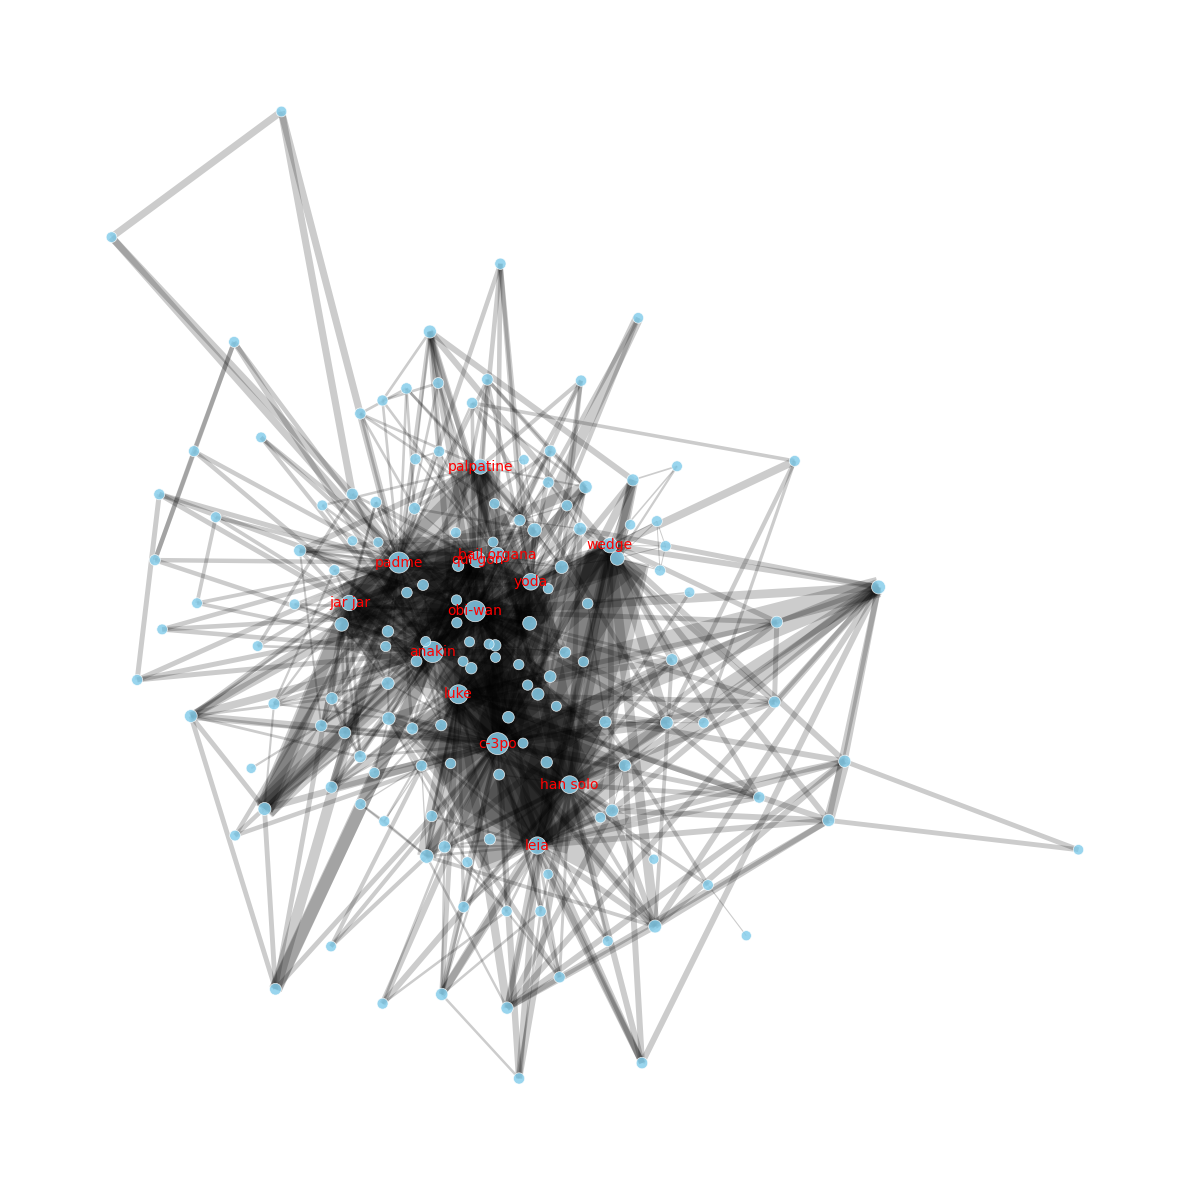

In [247]:
edge_weights = defaultdict(int)

for where,grp in df_merged.groupby('where'):
    w = len(grp)
    chars = grp['matched_name'].dropna().unique()
    for a,b in combinations(sorted(chars),2):
        edge_weights[(a,b)] += w

G = nx.Graph()
G.add_weighted_edges_from((a,b,w) for (a,b),w in edge_weights.items())

visualize(G,label_threshold=20)

# Network Analysis

### Functions/Imports

In [258]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
import community as community_louvain
import random

def visualize_communities(G, communities, label_threshold=5):
    pos = nx.kamada_kawai_layout(G)
    sorted_comms = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    comm_ids = [cid for cid, _ in sorted_comms]
    cmap = get_cmap('tab20')
    node_index = {n: i for i, (_, members) in enumerate(sorted_comms) for n in members}
    node_colors = [cmap(node_index[n] / len(comm_ids)) for n in G]
    deg = dict(G.degree())
    node_sizes = [50 + 200 * (deg[n] / max(deg.values())) for n in G]
    edge_widths = [0.1 * G[u][v].get('weight', 1) for u, v in G.edges]

    fig, ax = plt.subplots(figsize=(12, 12), dpi=100)
    nx.draw_networkx_nodes(G, pos,
                           node_color=node_colors,
                           node_size=node_sizes,
                           alpha=0.85,
                           linewidths=0.5,
                           edgecolors='white')
    nx.draw_networkx_edges(G, pos,
                           width=edge_widths,
                           alpha=0.2)
    labels = {n: n for n, d in deg.items() if d >= label_threshold}
    nx.draw_networkx_labels(G, pos,
                            labels,
                            font_size=10,
                            font_color='red')

    handles = [
        Patch(color=cmap(idx / len(comm_ids)), label=f'Community {cid}')
        for idx, cid in enumerate(comm_ids)
    ]
    ax.legend(handles=handles, title='Community', bbox_to_anchor=(1, 1))
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

### 1. Basic Metrics

In [242]:
print("Number of nodes in Network: ", len(G.nodes()))
print("Number of edges in Network: ", len(G.edges()))

Number of nodes in Network:  152
Number of edges in Network:  623


**Degree:** Characters with most connections

In [243]:
degree = dict(nx.degree(G))

print("Top 5 by degree:")
print(sorted(degree.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 by degree:
[('c-3po', 64), ('anakin', 58), ('obi-wan', 58), ('padme', 58), ('luke', 44)]


*Interpretation*: 

These are the characters which are included in the most scenes, i.e. main characters (at least determined by screen time)

**Centrality :** Which characters are bridges between groups

In [244]:
centrality = nx.betweenness_centrality(G)

print("Top 5 by betweenness centrality:")
print(sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 by betweenness centrality:
[('c-3po', 0.2420388328124488), ('obi-wan', 0.20342861574329396), ('anakin', 0.15009084924782629), ('padme', 0.14960532363981272), ('luke', 0.11004069289297476)]


*Interpretation*: 

C-3PO is the most common characters bridging gaps between otherwise unconnected nodes, i.e. he is in the "middle". The other characters represent this as well, although not as big scale.

**Closeness :** Who has access to others quickly (in terms of dialogue chains)

In [ ]:
closeness = nx.closeness_centrality(G)

print("Top 5 by closeness:")
print(sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:5])


Top 5 by closeness:
[('c-3po', 0.6141886706648096), ('obi-wan', 0.5962748344370862), ('anakin', 0.5793763573477759), ('padme', 0.5462059552095445), ('luke', 0.5359773792692909)]


*Interpretation*:

This displays the connectedness/closeness of characters. It makes sense that C-3PO is also close to many, as he is also connecting many in Centrality.

Moreover, characters like Obi-Wan and Anakin rank highly, reflecting their roles as main parts of the story that make connections across different groups. High closeness indicates that these characters can rapidly distribute information or influence through our network, making them key characters of the plot.  


### 2. Community Detection

Louvain Method (for modularity-based clustering)

Show all (7) Communities:
Community 0: ['aks moe', 'at-st clone sergeant', 'bail organa', 'bana breemu', 'bodyguard']...
Community 1: ['aayla', 'bly']...
Community 2: ['ackbar', 'announcer', 'beru', 'bib', 'boba fett']...
Community 3: ['owo-1', 'tc14']...
Community 4: ['bartender', 'biggs', 'camie', 'creature', 'deak']...
Community 5: ['amee', 'anakin', 'battle droid', 'clone captain', 'cordé']...
Community 6: ['communications officer', 'needa', 'ozzel', 'piett', 'veers']...


C:\Users\lucas\AppData\Local\Temp\ipykernel_19420\1652875224.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


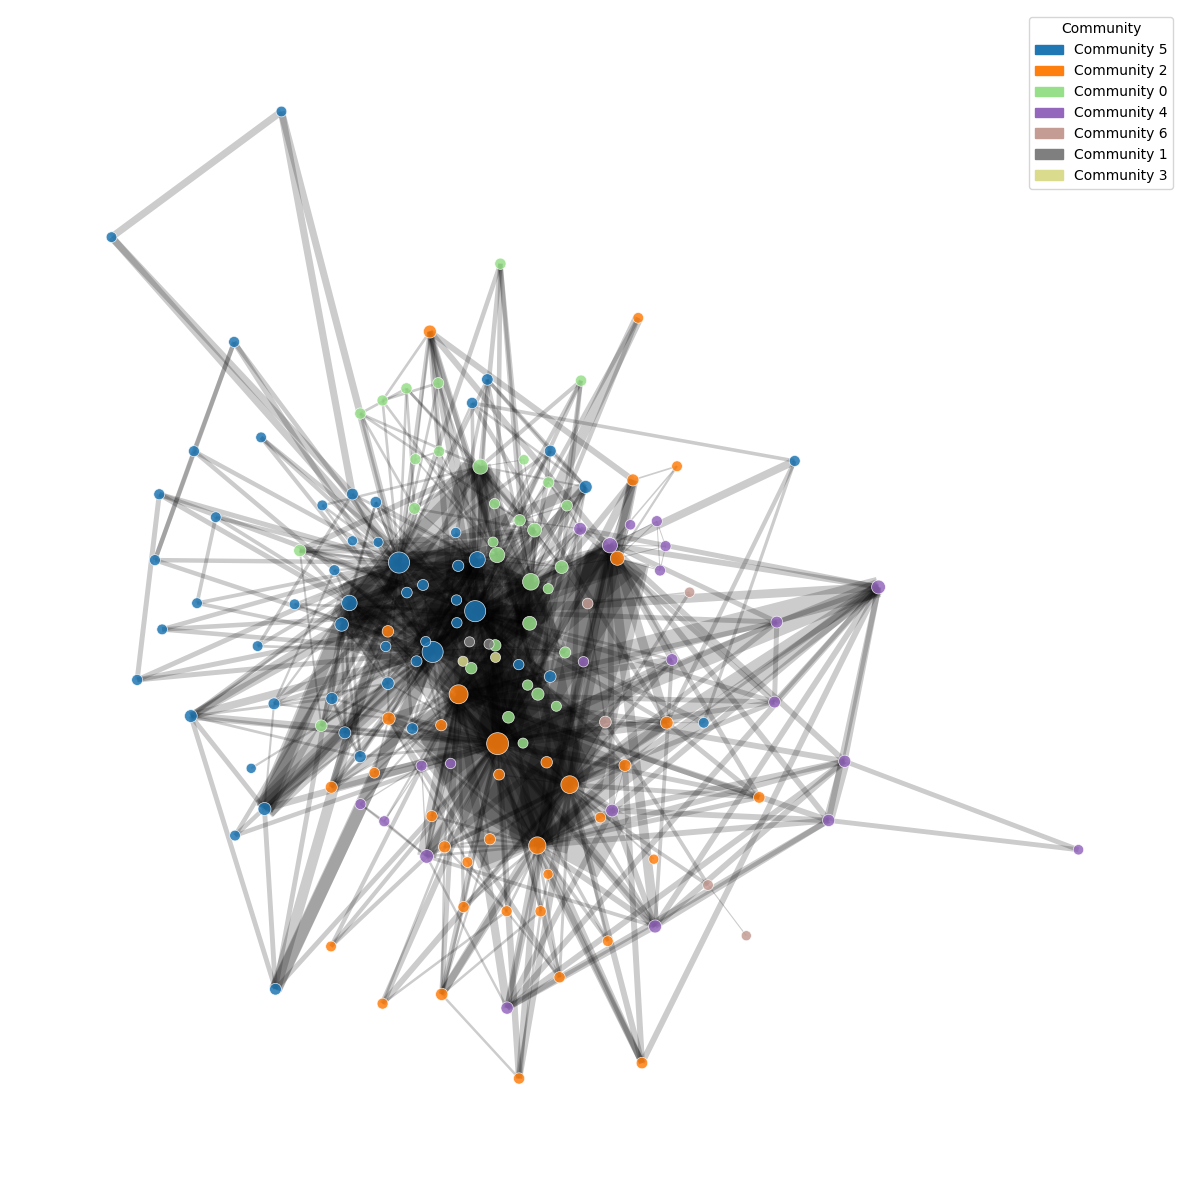

In [279]:
random.seed(33)
np.random.seed(33)

# create the communities
raw_partition = community_louvain.best_partition(
    G,
    resolution=1,
    randomize=False
)

# for reproducibility
unique_raw = sorted(set(raw_partition.values()))
reindex    = {old: new for new, old in enumerate(unique_raw)}
partition  = {
    node: reindex[raw_partition[node]]
    for node in sorted(G.nodes())
}

nx.set_node_attributes(G, partition, "community")
communities = defaultdict(list)
for node in sorted(G.nodes()):
    communities[partition[node]].append(node)

df_merged['community'] = df_merged['matched_name'].map(partition)

num_communities = len(communities)
print(f"Show all ({num_communities}) Communities:")
for cid in sorted(communities):
    members = communities[cid]
    print(f"Community {cid}: {members[:5]}...")

visualize_communities(G, communities, label_threshold=100)

In [330]:
# creates df with only unique characters and all features, to calculate similarness of attributes for each community
df_unique   = (
    df_merged
    .drop_duplicates(subset='from')
    .drop(columns=['text','text_processed','movie_num','matched_name','where','name','pronouns'])
    .reset_index(drop=True)
    )

# precompute global frequencies including NaNs
global_freq = {
    col: df_unique[col].value_counts(normalize=True, dropna=False)
    for col in df_unique.columns.drop('community')
}

community_similarity = {}

for cid, group in df_unique.groupby('community'):
    size = len(group)
    col_stats = []

    for col in group.columns.drop('community'):
        group_freq = group[col].value_counts(normalize=True, dropna=False)
        if group_freq.empty:
            continue

        top_val = group_freq.index[0]
        if pd.isna(top_val):
            continue

        p_comm = group_freq[top_val]
        p_glob = global_freq[col].get(top_val, 0)
        diff_pct = (p_comm - p_glob) * 100
        if diff_pct <= 0:
            continue

        col_stats.append({
            'column': col,
            'value': top_val,
            'comm_pct': p_comm * 100,
            'global_pct': p_glob * 100,
            'diff_pct': diff_pct
        })

    top3 = sorted(col_stats, key=lambda x: x['diff_pct'], reverse=True)[:3]
    community_similarity[cid] = top3

    print(f"Community {cid}, size {size}:")
    if top3:
        for stat in top3:
            print(
                f"  '{stat['column']}' = '{stat['value']}': "
                f"community {stat['comm_pct']:.1f}%, "
                f"global {stat['global_pct']:.1f}%, "
                f"diff {stat['diff_pct']:.1f}%"
            )
    else:
        print("  no overrepresented values")

Community 0.0, size 32:
  'trilogy' = '1': community 90.6%, global 50.8%, diff 39.8%
  'affiliation' = 'Galactic Republic': community 50.0%, global 11.4%, diff 38.6%
  'species' = 'Human (clone)': community 28.1%, global 6.3%, diff 21.8%
Community 1.0, size 2:
  'from' = 'aayla': community 50.0%, global 0.4%, diff 49.6%
  'death' = '19 BBY, Felucia': community 50.0%, global 0.4%, diff 49.6%
  'height' = '1.7 meters (5 ft, 7 in)': community 50.0%, global 0.4%, diff 49.6%
Community 2.0, size 36:
  'trilogy' = '2': community 80.6%, global 43.3%, diff 37.2%
  'gender' = 'Male': community 58.3%, global 34.3%, diff 24.1%
  'species' = 'Human': community 41.7%, global 25.2%, diff 16.5%
Community 3.0, size 2:
  'affiliation' = 'Trade Federation': community 100.0%, global 2.8%, diff 97.2%
  'from' = 'owo-1': community 50.0%, global 0.4%, diff 49.6%
  'death' = '32 BBY, Saak'ak, Naboo system': community 50.0%, global 0.4%, diff 49.6%
Community 4.0, size 22:
  'trilogy' = '2': community 95.5%, gl

*Interpretation*: 

Below is our intepretation of what each community is based on, from our analysis above on matching attributes for each community. 

Community 0: Primarily characters from the first trilogy (episode 1-3), primarily from the Galactic Republic. The rest are most likely indirectly connected to character from this affiliation, placing them in this community.


Community 1: Very small community of 2 and nothing is mathcing between them from the attributes view. 


Community 2: Characters from second triology (episode 4-6), containing mostly male human characters. Again the rest are most likely  highly connected to the male humans from trilogy 2.


Community 3: Containing 2 characters only connected by their affilation, The Trade Federation.


Community 4: This community is close to community 2 in their most shared attributes being trilogy 2, human males. 


Community 5: Characters from triology 1, mostly male humans. The members that are not male or human are most likely highly connected to males and humans.


Community 6: Small group of humans from the second trilogy, 3/5 being affiliated with the Galactic republic.


From out interpretation of these communities, we observe how community 2 and community 4 seems to be the same. We will therefore use word clouds for all communities, but especially for those who seem similar at first, to find hidden relationships and distinguish between them.

#### Wordclouds of Communities

In [327]:
import re
import math
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import chi2
from PIL import Image
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.corpus import stopwords

# ————— Globals —————
ps = PorterStemmer()
STOPWORDS = set(stopwords.words('english'))

# ————— 1) Preprocess & Stem —————
def preprocess_and_stem(texts):
    """
    Lowercase, tokenize, drop non-alpha, stopwords, <2-char tokens, then stem.
    Returns a flat list of stemmed tokens.
    """
    out = []
    for doc in texts:
        doc = doc.lower()
        for w in word_tokenize(doc):
            w = re.sub(r'[^a-z]', '', w)
            if len(w)<2 or w in STOPWORDS:
                continue
            out.append(ps.stem(w))
    return out

# ————— 2) Find significant bigrams (χ²) —————
def find_collocations(tokens, min_count, pval_thresh):
    """
    From a flat token list, build all bigrams, count them,
    compute 2×2 tables and χ² p-value, return only those
    bigrams with count>=min_count and p<pval_thresh.
    """
    bigrams = [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]
    bc = Counter(bigrams)
    c1 = Counter(w1 for w1,_ in bigrams)
    c2 = Counter(w2 for _,w2 in bigrams)
    total = len(bigrams)
    coll = []
    for bg, cnt in bc.items():
        if cnt < min_count: 
            continue
        # observed
        n11 = cnt
        n10 = c1[bg[0]] - n11
        n01 = c2[bg[1]] - n11
        n00 = total - (n11 + n10 + n01)
        # expected
        R1, R2 = n11+n10, n01+n00
        C1, C2 = n11+n01, n10+n00
        E11 = R1*C1/total; E12 = R1*C2/total
        E21 = R2*C1/total; E22 = R2*C2/total
        # χ²
        chi2_val = 0
        for O,E in [(n11,E11),(n10,E12),(n01,E21),(n00,E22)]:
            if E>0:
                chi2_val += (O - E)**2 / E
        if chi2.sf(chi2_val,1) < pval_thresh:
            coll.append(bg)
    return coll

# ————— 3) Collapse tokens by collocations —————
def collapse_tokens(tokens, collocations):
    """
    Given flat tokens & a list of significant bigram tuples,
    merge them via MWETokenizer into single tokens with '_'.
    """
    mwe = MWETokenizer(collocations, separator='_')
    return mwe.tokenize(tokens)

# ————— 4) Generate collapsed token lists per community —————
def generate_collapsed_tokens_by_comm(df, num_comms, min_count, pval_thresh):
    """
    Returns a dict community_id → list of collapsed tokens.
    """
    result = {}
    for cid in range(num_comms+1):
        texts = df.loc[df.community==cid, 'text_processed'].dropna().tolist()
        if not texts:
            continue
        tokens = preprocess_and_stem(texts)
        if not tokens:
            continue
        coll = find_collocations(tokens, min_count, pval_thresh)
        collapsed = collapse_tokens(tokens, coll) if coll else tokens
        result[cid] = collapsed
    return result

# ————— 5) Compute IDF across communities —————
def compute_idf(collapsed_by_comm):
    """
    collapsed_by_comm: dict cid → token-list.
    IDF(t) = log(N / df_t) where df_t = #communities containing t.
    """
    N = len(collapsed_by_comm)
    dfreq = Counter()
    for toks in collapsed_by_comm.values():
        dfreq.update(set(toks))
    return {t: math.log(N/dfreq[t]) for t in dfreq}

# ————— 6) Compute TF×IDF for one comm’s freq dict —————
def compute_tfidf(freqs, idf):
    """
    freqs: Counter(tokens) for one community.
    idf: as from compute_idf.
    """
    return {t: freqs[t] * idf.get(t, 0) for t in freqs}

# ————— 7) Mask loader / Cloud maker / Plotter —————
def load_mask(mask_path):
    try:
        return np.array(Image.open(mask_path))
    except:
        print('MASK NOT WORKING')

def make_wordcloud(freqs, mask=None):
    wc = WordCloud(width=800, height=400, background_color='white', mask=mask)
    wc.generate_from_frequencies(freqs)
    return wc

def plot_wordcloud(wc, title):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# ————— 8) One-line: create & show for a single community —————
def create_wordcloud(comm_id, collapsed_by_comm, idf, mask_path=None):
    toks = collapsed_by_comm.get(comm_id)
    if not toks:
        print(f"No tokens for community {comm_id}")
        return None

    freqs = Counter(toks)
    tfidf = compute_tfidf(freqs, idf)
    mask = load_mask(mask_path) if mask_path else None

    wc = make_wordcloud(tfidf, mask)
    plot_wordcloud(wc, f"Community {comm_id}")
    return wc

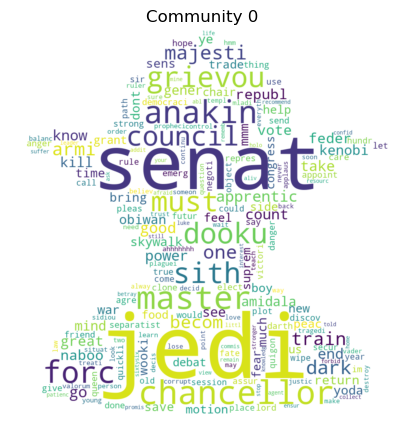

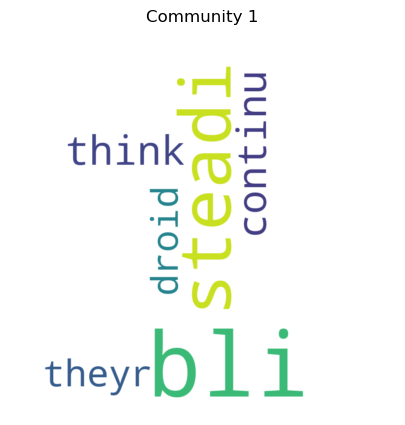

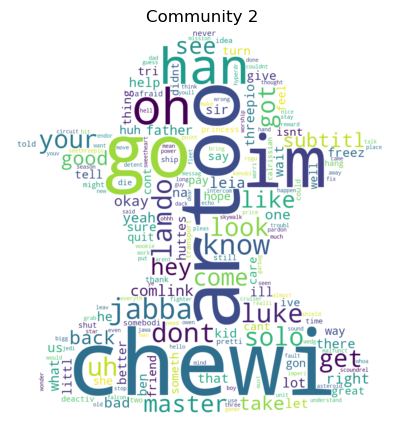

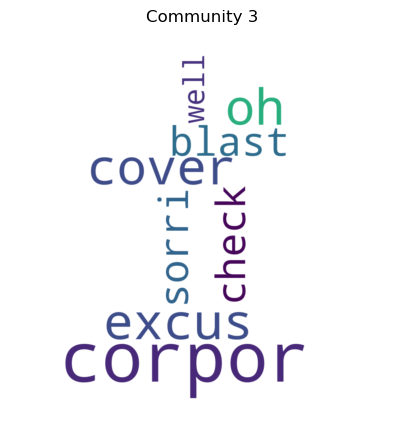

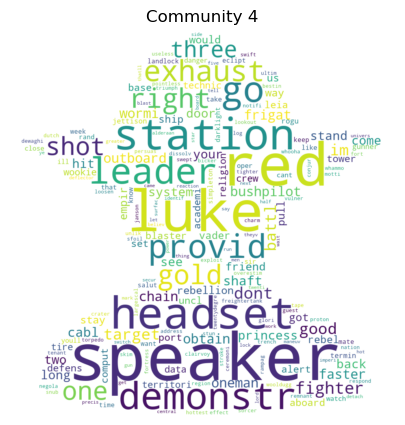

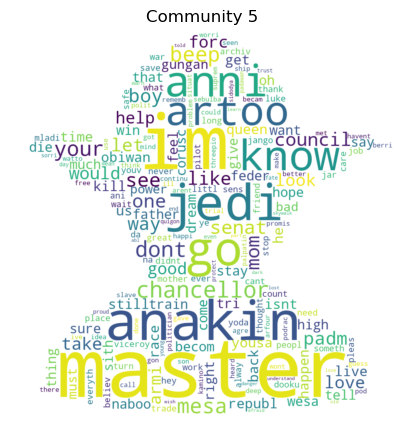

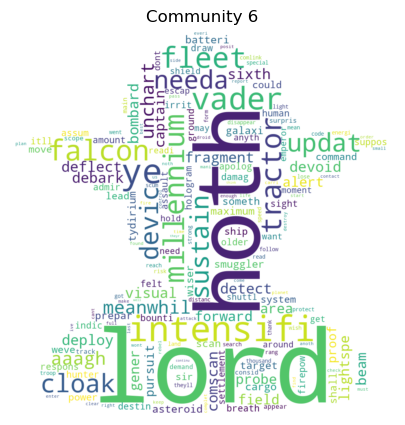

In [328]:
mask = '../wordcloud_masks/yoda.png'

collapsed = generate_collapsed_tokens_by_comm(df_merged, num_communities, 50, 0.001)
idf_vals  = compute_idf(collapsed)

for cid in sorted(collapsed):
    create_wordcloud(cid, collapsed, idf_vals, mask)

### 4. Critical characters (for connectivity)

Finding critical bridges, characters that if removed ruins connectivity of the network.

In [ ]:
# find critical connectors (bridges)
bridges = list(nx.bridges(G))  # edges that, if removed, would disconnect parts
print("top 5 bridges:", bridges[:5])

top 5 bridges: [('anakin', 'battle droid'), ('padme', 'cordé'), ('padme', 'sabe'), ('han solo', 'greedo'), ('leia', 'willard')]


Removing a critical character to see how connectivity changes (Example Palpatine)

In [ ]:
# see Palpatine neighbors (see if he connects isolated subgroups)
neighbors = list(G.neighbors("Palpatine"))
print("Palpatine interacts with:", neighbors)

# removing Palpatine
G_removed = G.copy()
G_removed.remove_node("Palpatine")

# see connectivity
components = list(nx.connected_components(G_removed))
print("components without Palpatine:", len(components))

NetworkXError: The node Palpatine is not in the graph.